# 18-9. 프로젝트 : 다양한 OCR모델 비교하기

OCR 기술을 활용할 방법과 3가지 OCR 모델의 성능을 비교해보기 


OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

## Step1. 검증용 데이터셋 준비

축구 유니폼.

축구 통계들을 사람이 직접 기록해야한다. 또한 선수의 몸형태를 통해서도 인식할수있다.

보조적인 방법으로 

출처 조선일보 https://www.chosun.com/site/data/html_dir/2019/03/08/2019030800265.html

출처 풋볼 리스트 http://www.footballist.co.kr/news/articleView.html?idxno=96837

축구선수들의 등번호와 마킹된 이름 즉 name set을 인식할수있다면

그 선수의 전체적인 움직임을 더 쉽게 인지할 수 있지 않을까 싶다.


예상되는 문제점: 유니폼들은 번쩍 거림. 

In [1]:
import os
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

# keras_ocr
import keras_ocr

# 테서랙트
import pytesseract
from pytesseract import Output

In [2]:
tar_path = os.path.join(os.getenv("HOME"), 'aiffel', 'ocr_python', 'images')
tar_path

'/home/ssac4/aiffel/ocr_python/images'

In [3]:
img_paths = glob(tar_path+'/*')
img_paths

['/home/ssac4/aiffel/ocr_python/images/11.png',
 '/home/ssac4/aiffel/ocr_python/images/6.png',
 '/home/ssac4/aiffel/ocr_python/images/3.png',
 '/home/ssac4/aiffel/ocr_python/images/5.png',
 '/home/ssac4/aiffel/ocr_python/images/1.png',
 '/home/ssac4/aiffel/ocr_python/images/9.png',
 '/home/ssac4/aiffel/ocr_python/images/4.png',
 '/home/ssac4/aiffel/ocr_python/images/7.png',
 '/home/ssac4/aiffel/ocr_python/images/2.png',
 '/home/ssac4/aiffel/ocr_python/images/8.png',
 '/home/ssac4/aiffel/ocr_python/images/10.png']

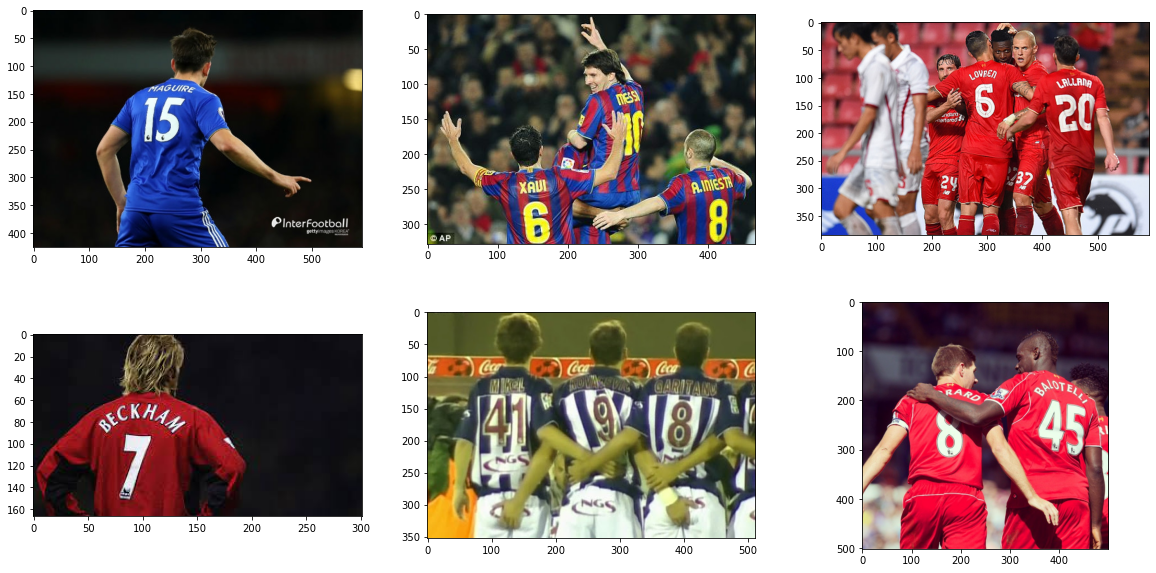

In [7]:
plt.figure(figsize=(20, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    pil_img = Image.open(img_paths[np.random.randint(len(img_paths))])
    plt.imshow(pil_img)
plt.show()

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

In [8]:

def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [9]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

# 입력 이미지 경로를 지정해 주세요.
# 20개의 모든 이미지는 너무 많기 때문에 랜덤하게 5개의 사진만 진행
for i in range(5):
    print(f'{i+1}번째 이미지\n')
    detect_text(img_paths[np.random.randint(len(img_paths))])
    print("-"*20+'\n\n')

total 1228
drwxr-xr-x 2 ssac4 ssac4    4096  3월 17 02:05  folder
drwxr-xr-x 2 ssac4 ssac4    4096  3월 17 02:32  images
-rw-rw-r-- 1 ssac4 ssac4  223422  3월 17 01:06  l.jpg.crdownload
-rw-rw-r-- 1 ssac4 ssac4    2367  3월 16 17:19  my_google_api_key.json
-rw-r--r-- 1 ssac4 ssac4 1009852  3월 17 02:34 'OCR 모델 비교 REPORT.ipynb'
-rw-r--r-- 1 ssac4 ssac4    4138  3월 17 00:44  Untitled.ipynb
1번째 이미지



DefaultCredentialsError: Could not automatically determine credentials. Please set GOOGLE_APPLICATION_CREDENTIALS or explicitly create credentials and re-run the application. For more information, please see https://cloud.google.com/docs/authentication/getting-started

Looking for /home/ssac4/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/ssac4/.keras-ocr/crnn_kurapan.h5


/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


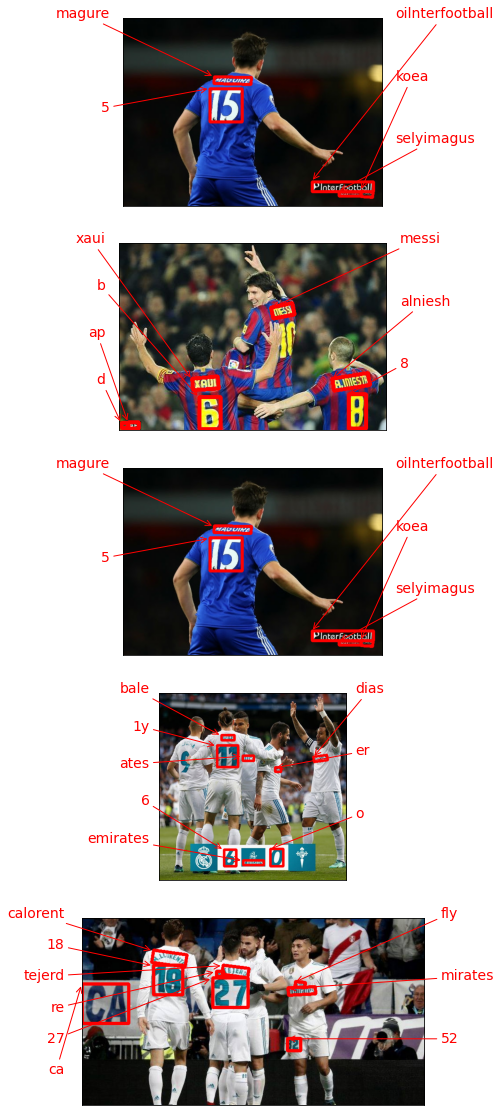

In [4]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

random_idx = np.random.choice(np.arange(len(img_paths)), 5)

image_paths = []
for i in random_idx :
    image_paths.append(img_paths[i])

images = [ keras_ocr.tools.read(path) for path in image_paths]
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

잘 인식하면서도 각도가 잘못되다보니 조금씩 잘못인식한게 보인다.

결국 축구선수들 이름을 구별만 하면 될수있기 때문에. 

maguire 선수를 magure로 인식하는덴 일종의 자연어 처리를 하면서 비슷한 단어는 같게 인식하도록 만들면 문제를 해결 할 수 있지 않을까 

## Tesseract


In [8]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
#             print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [10]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
# img_file_path = work_dir + '/images/13.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 
cropped_image_path_list = []
for i in range(len(image_paths)) :
    img_file_path = image_paths[i]
    if not os.path.exists(os.path.join(work_dir, f'result_{i}')) :
        os.makedirs(os.path.join(work_dir, f'result_{i}'))
    
    tmp = crop_word_regions(img_file_path, os.path.join(work_dir, f'result_{i}'))
    print(f'{i+1}번째 이미지 완료')
    cropped_image_path_list.extend(tmp)

1번째 이미지 완료
2번째 이미지 완료
3번째 이미지 완료


SystemError: tile cannot extend outside image

## Step3. 테스트 결과 정리

모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

## Step4. 결과 분석과 결론 제시

우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가기준을 제시합니다.
그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

# 소고 

스포츠 분야의 데이터 수집과 편집에 ocr, computer vision, 자연어 처리(팬들의 반응)이 활용된다면

더 재미있는 세상이 되지 않을까 싶다. 